# Q22 Quick Start
### **Introduction to S&P500 stocks**

This template demonstrates how to build a trading strategy, specifically designed for use with a dataset containing historical constituents of the S&P 500. The strategy can only trade stocks that are part of the S&P 500 index, and only when the stock is considered liquid. A company is deemed liquid if it is included in the S&P 500 at the observed point in time.

The strategy takes a low-risk approach by allocating weights to stocks based on their volatility. It assigns capital only when the ratio of the Average True Range (ATR) to the closing price is below 0.0205, signaling lower volatility. The allocation is further refined by the stock's transaction money flow, where stocks with higher liquidity and trading volume receive a larger portion of the capital (weight). This approach ensures that more capital is directed towards assets with higher market activity, while also maintaining a risk-aware allocation.

**Important Considerations:**

- Trade only on historical S&P 500 stocks, and only when they are considered liquid (i.e., part of the index at the time of observation).
- The in-sample period begins on 2006-01-01. Earlier data may be used for testing and training purposes.
- The strategy must achieve a minimum in-sample Sharpe Ratio of 0.70 to be considered valid.
- The maximum allocation to any single asset is capped at 10% of total capital. If a weight exceeds this, it will be limited to 0.1. Other normalization methods are allowed.
- Manual stock selection or direct hand-picking is not permitted. The allocation process must be [systematic](https://quantiacs.com/documentation/en/user_guide/dynamic_assets_selection.html).
- The strategy can open both long and short positions.

For official Q22 rules, click [here](https://quantiacs.com/contest/22).





### **Accessing the S&P 500 Stocks Dataset - Data loading**

For the Q22 contest, a new dataset of S&P 500 stocks is available. You can obtain this dataset by calling the function stocks_load_spx_data() from the data module:

```python
snp_stocks_data = qndata.stocks_load_spx_data(min_date='2005-06-01')
```

To check the list of S&P 500 companies starting from 2006-01-01, along with additional stock information, use the load_list() function:


```python
snp_stocks_list = qndata.stocks_load_spx_list()
```

**Quantiacs** also provides data for other instruments, such as [cryptocurrencies](https://quantiacs.com/documentation/en/data/crypto.html), [indices](https://quantiacs.com/documentation/en/data/indexes.html), [futures](https://quantiacs.com/documentation/en/data/futures.html), as well as additional [fundamental stock](https://quantiacs.com/documentation/en/data/fundamental.html) data and [macroeconomic](https://quantiacs.com/documentation/en/data/bls.html) data. Note that there is also a [Nasdaq-100](https://quantiacs.com/documentation/en/data/stocks.html#stocks-nasdaq100) dataset available, and it is not a subset of the S&P 500. However, there is a significant overlap between the two.


The data is provided in xarray.DataArray format. Check [here](https://quantiacs.com/documentation/en/data/intro.html#working-with-data) for more details on manipulating [xarray](https://quantiacs.com/documentation/en/data/intro.html#xarray) data.



**Technical analysis - indicators**

Once the data is loaded, various technical indicators from the qnt.ta module can be used to generate trading signals. For a complete list of indicators and examples of their implementation, check the [documentation](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html) page.

### **Trading strategy - algorithm**

In [39]:
# Necessary imports
import xarray as xr
import numpy as np

import qnt.stats as qnstats
import qnt.data as qndata
import qnt.output as qnout
import qnt.ta as qnta
import qnt.backtester as qnbt
import qnt.graph as qngraph



def strategy(data, state=None, mfsp=135, limit=0.0205):
    vol = data.sel(field="vol")  ### Volume values
    liq = data.sel(field="is_liquid")  ### Liquidity values, 1.0 or 0.0 -> True or False
    close = data.sel(field="close")  ### close prices
    high = data.sel(field="high")  ### daily high
    low = data.sel(field="low")  ### daily low

    atrs = qnta.atr(high=high, low=low, close=close, ma=14)  ### Average True Range of 14 days
    ratio = atrs / close  ### indicator
    weights = xr.where(ratio > limit, 0, 1)  ### Strategy condition

    money_vol = vol * liq * close  ### Daily money flow per liquid asset
    total_money_vol = money_vol.sum(dim='asset', skipna=True)  ### Total daily money flow of liquid assets
    money_vol_share = money_vol / total_money_vol  ### Daily money flow share per liquid asset
    mvs_mov = qnta.sma(money_vol_share, mfsp)  ### weights allocation by average money flow share in period

    return mvs_mov * weights


#### **Weights - Single / Multi pass approach**

In [Single](https://quantiacs.com/documentation/en/user_guide/functional_quality.html#single-pass-backtesting) pass backtesting, which is significantly faster, weights are calculated in one run through the dataset. 

[Multi](https://quantiacs.com/documentation/en/user_guide/functional_quality.html#multi-pass-backtesting) pass backtesting evaluates weights on a day-by-day basis by slicing the dataset for each individual day.


If applicable, we recommend using the single pass approach for efficiency, while verifying strategy statistics with the multi pass backtester. If the statistics from single pass and multi pass match exactly, it indicates that forward-looking bias has likely not been introduced, and the strategy can be confidently submitted as single pass.

In rare cases, even if results are identical between single and multi pass, forward-looking bias might unintentionally occur (e.g., by incorporating global data variables into the logic). Such issues are generally mitigated in production but can result in discrepancies in statistics comparing development and production results.


In [36]:
### SINGLE PASS ###

## The min_date parameter is set to '2005-06-01' to ensure that the dataset includes at least 135 bars (approximately 190 days) of data,
## which is necessary for creating indicators and determining weights for the strategy.
snp_stocks_data = qndata.stocks_load_spx_data(min_date='2005-06-01')

weights = strategy(snp_stocks_data)
weights = qnout.clean(weights, snp_stocks_data) # fix liquidity

fetched chunk 1/17 0s
fetched chunk 2/17 0s
fetched chunk 3/17 0s
fetched chunk 4/17 0s
fetched chunk 5/17 0s
fetched chunk 6/17 0s
fetched chunk 7/17 0s
fetched chunk 8/17 1s
fetched chunk 9/17 1s
fetched chunk 10/17 1s
fetched chunk 11/17 1s
fetched chunk 12/17 1s
fetched chunk 13/17 1s
fetched chunk 14/17 1s
fetched chunk 15/17 1s
fetched chunk 16/17 1s
fetched chunk 17/17 1s
Data loaded 2s
Output cleaning...
All wieghts will be set to max_exposure limit 0.1
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.




When using the backtester for weight calculation, there is no need to manually load data or define a "load_data" function as input. It is only required to specify the competition_type (in this case, "stocks_s&p500"), and the corresponding data will be loaded automatically by default.



In [40]:
### MULTI PASS ###

w=qnbt.backtest(
    competition_type="stocks_s&p500",
    lookback_period=250,
    start_date="2006-01-01",
    strategy=strategy,
    analyze=True,
 )

Run last pass...
Load data...
fetched chunk 1/1 0s
Data loaded 0s
Run strategy...
Load data for cleanup...
fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
All wieghts will be set to max_exposure limit 0.1
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write result...
Write output: /root/fractions.nc.gz
---
Run first pass...
Load data...
fetched chunk 1/1 0s
Data loaded 0s
Run strategy...
---
Load full data...
fetched chunk 1/17 0s
fetched chunk 2/17 0s
fetched chunk 3/17 0s
fetched chunk 4/17 1s
fetched chunk 5/17 1s
fetched chunk 6/17 1s
fetched chunk 7/17 1s
fetched chunk 8/17 1s
fetched chunk 9/17 1s
fetched chunk 10/17 1s
fetched chunk 11/17 1s
fetched chunk 12/17 1s
fetched chunk 13/17 2s
fetched chunk 14/17 2s
fetched chunk 15/17 2s
fetched chunk 16/17 2s
fetched chunk 17/17 2s
Data loaded 3s
---
Run iterations...



100% (4702 of 4702) |####################| Elapsed Time: 0:03:24 Time:  0:03:24


Merge outputs...
Load data for cleanup and analysis...
fetched chunk 1/17 0s
fetched chunk 2/17 0s
fetched chunk 3/17 1s
fetched chunk 4/17 1s
fetched chunk 5/17 1s
fetched chunk 6/17 1s
fetched chunk 7/17 1s
fetched chunk 8/17 1s
fetched chunk 9/17 1s
fetched chunk 10/17 1s
fetched chunk 11/17 2s
fetched chunk 12/17 2s
fetched chunk 13/17 2s
fetched chunk 14/17 2s
fetched chunk 15/17 2s
fetched chunk 16/17 2s
fetched chunk 17/17 2s
Data loaded 2s
Output cleaning...
All wieghts will be set to max_exposure limit 0.1
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write result...
Write output: /root/fractions.nc.gz
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2024-09-09
Sharpe Ratio = 0.8699080591576087
Ok.
---
Align...
Calc global stats...
---
Calc stat

interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

#### **Statistics**

While the multi pass approach automatically displays the strategy’s statistics through the backtester, single pass mode only calculates the weights, so visualizing the stats must be done manually. You can use the helper print_stats function for this purpose:


In [27]:
def print_stats(stats):
    display(stats.sel(time=slice('2006-01-01', None)).to_pandas().tail(10))

    performance = stats.to_pandas()["equity"]
    qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

def get_sharpe(stats):
    return stats.isel(time=-1).sel(field="sharpe_ratio").item()


field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2024-08-26,2.144029,0.000712,0.048049,-0.002737,-0.077881,0.870035,0.041804,1.0,605.0,0.029328,27.736062
2024-08-27,2.144836,0.000376,0.048044,-0.002362,-0.077881,0.870375,0.041816,1.0,605.0,0.029327,27.735747
2024-08-28,2.144186,-0.000303,0.048039,-0.002664,-0.077881,0.869924,0.041790,1.0,605.0,0.029324,27.735033
2024-08-29,2.146733,0.001188,0.048034,-0.001480,-0.077881,0.871199,0.041847,1.0,605.0,0.029322,27.734825
2024-08-30,2.151655,0.002293,0.048032,0.000000,-0.077881,0.873722,0.041966,1.0,605.0,0.029318,27.734108
2024-09-03,2.147670,-0.001852,0.048029,-0.001852,-0.077881,0.871426,0.041854,1.0,607.0,0.029314,27.733633
2024-09-04,2.148320,0.000303,0.048024,-0.001550,-0.077881,0.871682,0.041861,1.0,607.0,0.029316,27.723459
2024-09-05,2.144098,-0.001965,0.048021,-0.003512,-0.077881,0.869251,0.041742,1.0,607.0,0.029313,27.721291
2024-09-06,2.138999,-0.002379,0.048020,-0.005882,-0.077881,0.866320,0.041600,1.0,607.0,0.029311,27.718681


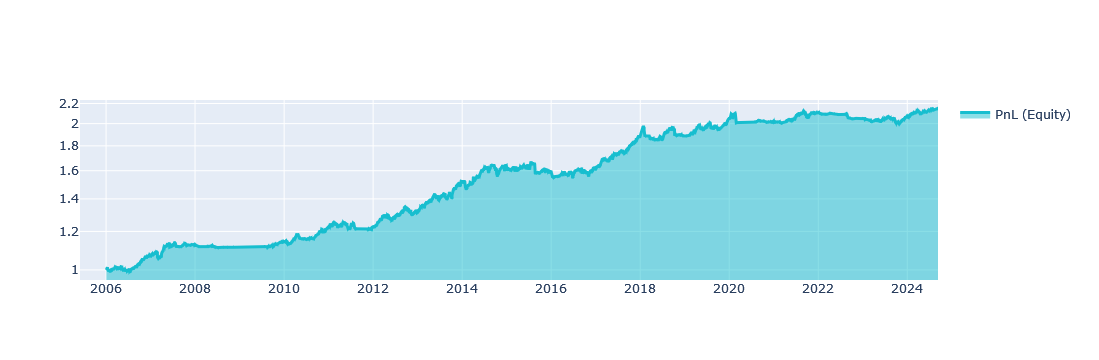

In [38]:
stats = qnstats.calc_stat(snp_stocks_data, weights.sel(time=slice('2006-01-01', None)))
print_stats(stats)  #normalize_by_max_exposure(w, 0.1))

In [29]:
get_sharpe(stats)

0.855950300476403

#### **Submit strategy to the competition**

> Use **Submit** button on my strategies page

Make sure that qnout.write(weights) has been added to cell, and the weights have been written.

It is not required when using Multi pass backtester.

In [30]:
qnout.write(weights)

Write output: /root/fractions.nc.gz


**Note:** After submitting the strategy to the contest, any weight exceeding 0.1 will be capped at that limit. You can apply weight normalization functions before submission, which may be more suitable, such as those that maintain the ratio between allocated weights. Details on these functions can be found [here](https://quantiacs.com/documentation/en/user_guide/dynamic_assets_selection.html#risk-management).

### **Common Reasons for Submission Rejection and Their Solutions**

Here are some of the frequent reasons causing submission rejection in algorithmic trading competitions, and their corresponding remedies.

> [Detailed explanation with examples](https://quantiacs.com/documentation/en/user_guide/passFilters.html).

**1) Missed call to write_output**

Save algorithm weights,  run code

```python
qnt.output.write(weights)
```

**2) Not eligible send to contest. In-Sample Sharpe must be larger than 0.7**

Improve your algorithm. For example, you can use sections and get an algorithm that will pass the filter

* Example [Trading System Optimization](https://github.com/quantiacs/strategy-futures-ta-global-optimizer/blob/master/strategy.ipynb)
* Example of a strategy using [technical analysis indicators](https://github.com/quantiacs/strategy-predict-NASDAQ100-use-atr-lwma/blob/master/strategy.ipynb)

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.


**3) Not enough bid information.**

Run code

```python
min_time = weights.time[abs(weights).fillna(0).sum('asset')> 0].min()
min_time
```
> min_time must be less than or equal to January 1, 2006.

If min_time is larger than the starting date, we recommend to fill the starting values of the time series with non-vanishing values, for example a simple buy-and-hold strategy.

```python
def get_enough_bid_for(data_, weights_):
    time_traded = weights_.time[abs(weights_).fillna(0).sum('asset') > 0]
    is_strategy_traded = len(time_traded)
    if is_strategy_traded:
        return xr.where(weights_.time < time_traded.min(), data_.sel(field="is_liquid"), weights_)
    return weights_


weights_new = get_enough_bid_for(data, weights)
weights_new = weights_new.sel(time=slice("2006-01-01",None))
```